## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot
from from_neural_kernels import to_zca, CustomTensorDataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Conv(in_filters, out_filters, groups=1):
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, groups=groups, bias=False)
    conv.weight.data *= np.sqrt(3)
    return conv  

class Normalize(nn.Module):
    def forward(self, input):
        return nn.functional.normalize(input, p=2, dim=1, eps=1e-8)  

class ReLU2(nn.Module):
    C = np.sqrt(2)

    def forward(self, input):
        return F.relu(input, inplace=True) * self.C

class ResidualConnection(nn.Module):
    def __init__(self, *layers):
        super(ResidualConnection, self).__init__()
        self.layers = nn.Sequential(*layers)
    
    def forward(self, input):
        return (input + self.layers(input)) / 2.

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle10, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),     Activation(),

            #ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            #),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            #ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            #),
            Conv(filters, filters, groups),   Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            #ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            #),
            Conv(filters, filters, groups),   Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [0]:
class Myrtle5(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle5, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),   Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [0]:
class Myrtle7(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle7, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),   Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            

            Conv(filters, filters, groups), Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

## Cifar10

In [0]:
def get_cifar_zca():
  trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
  testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  X_train = np.asarray(trainset.data).astype(np.float64)
  y_train = np.asarray(trainset.targets)
  X_test  = np.asarray(testset.data).astype(np.float64)
  y_test  = np.asarray(testset.targets)

  (X_train, X_test), global_ZCA = to_zca(X_train, X_test)

  X_train = np.transpose(X_train, (0,3,1,2))
  X_test  = np.transpose(X_test,  (0,3,1,2))

  return X_train, y_train, X_test, y_test

In [9]:
%%time

X_train, y_train, X_test, y_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 2min 34s, sys: 12.7 s, total: 2min 47s
Wall time: 1min 28s


In [10]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long), transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

0.046048857

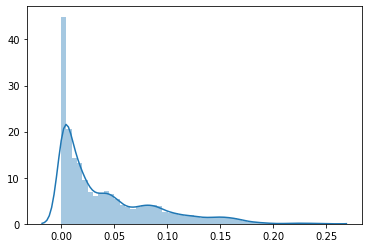

In [11]:
model = Myrtle10(num_filters=128, groups=2).to(device)
for batch_id, (X, y) in enumerate(train_loader):
  if batch_id > 20:
    break
  X, y = X.to(device), y.to(device)
  model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

In [12]:
from pytorch_impl.nns.utils import print_sizes

print_sizes(Myrtle10(num_filters=64).to(device))

torch.Size([64, 3, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([10, 64])
torch.Size([10])
297290


297290

In [0]:
model = Myrtle10(num_filters=256).to(device)

learning_rate = 0.07

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

# training.train(train_loader, test_loader, num_epochs=30, learning_rate=learning_rate)

In [0]:
# ClassifierTraining(estimator, device).get_accuracy(test_loader)

In [15]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 2min 34s, sys: 15.8 s, total: 2min 50s
Wall time: 1min 32s


In [0]:
N = 1280

X_train      = torch.tensor(X_train[:N]).float()
X_test       = torch.tensor(X_test[:N]).float()
labels_train = torch.tensor(labels_train[:N], dtype=torch.long)
labels_test  = torch.tensor(labels_test[:N],  dtype=torch.long)

In [17]:
labels_train[:10]

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [18]:
labels_test[:10]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [75]:
torch.manual_seed(0)
device = torch.device('cuda:0') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda', index=0)

In [0]:
def augment_X(X):
  def aug(x):
      return CustomTensorDataset.augment_x(x, 'flips') 
  return torch.stack([aug(x) for x in X])

In [77]:
X_train[:2].size()

torch.Size([2, 3, 32, 32])

In [78]:
augment_X(X_train[:2]).size()

torch.Size([2, 3, 32, 32])

In [0]:
def compute_kernels(models, X_train, X_test, device):
  with torch.no_grad():
    X_train = X_train.to(device)
    X_test  = X_test.to(device)
    
    n_train = len(X_train)
    n_test  = len(X_test)

    train_kernel = torch.zeros([n_train, n_train]).to(device)
    test_kernel  = torch.zeros([n_test,  n_train]).to(device)

    scale = np.sqrt(1. / 0.0156249953)

    m = 0
    start_time = time.time()

    for model_i, model in enumerate(models):
      model = model.to(device)
      if model_i & (model_i - 1) == 0:
        print(f"{model_i} models done. time {time.time() - start_time:.0f}s")

      train_features = scale * model.readout(X_train) 
      test_features  = scale * model.readout(X_test)

      m += train_features.size()[1]

      train_kernel += torch.matmul(train_features, train_features.T)
      test_kernel  += torch.matmul(test_features,  train_features.T)
    
    train_kernel /= m
    test_kernel  /= m
    
    return train_kernel, test_kernel

In [0]:
n_models = 5000

# 5000 * 32 = 160k

models = [Myrtle5(num_filters=32) for _ in range(n_models)]

In [104]:
%%time

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

train_kernel, test_kernel = compute_kernels(models, X_train, X_test, device)

0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 1s
8 models done. time 1s
16 models done. time 2s
32 models done. time 4s
64 models done. time 8s
128 models done. time 15s
256 models done. time 30s
512 models done. time 60s
1024 models done. time 120s
2048 models done. time 239s
4096 models done. time 478s
CPU times: user 5min 44s, sys: 3min 59s, total: 9min 43s
Wall time: 9min 43s


In [105]:
train_kernel[:5,:5]

tensor([[2.0000, 1.9893, 1.9845, 1.9930, 1.9878],
        [1.9893, 2.0000, 1.9880, 1.9909, 1.9916],
        [1.9845, 1.9880, 2.0000, 1.9837, 1.9915],
        [1.9930, 1.9909, 1.9837, 2.0000, 1.9856],
        [1.9878, 1.9916, 1.9915, 1.9856, 2.0000]], device='cuda:0')

In [106]:
test_kernel[:5,:5]

tensor([[1.9903, 1.9895, 1.9847, 1.9897, 1.9899],
        [1.9835, 1.9902, 1.9844, 1.9808, 1.9897],
        [1.9868, 1.9950, 1.9902, 1.9888, 1.9926],
        [1.9847, 1.9888, 1.9854, 1.9796, 1.9906],
        [1.9912, 1.9904, 1.9832, 1.9920, 1.9875]], device='cuda:0')

In [112]:
lr = 1e5

n = len(train_kernel)
reg = torch.eye(n).to(device) * 1e-3

exp_term = - lr * compute_exp_term(- lr * (train_kernel + reg), device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.6156, device='cuda:0')

In [108]:
"""
TODO experiments:
1. ZCA ✔️
2. random features ✔️
"""

'\nTODO experiments:\n1. ZCA ✔️\n2. random features ✔️\n'